In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
from glob import glob
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import random
import albumentations as A
import keras
import matplotlib.cm as cm
import plotly.express as px
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot.inputs.keras import PlotLossesCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score

In [2]:
pip install albumentations

  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
Note: you may need to restart the kernel to use updated packages.Installing collected packages: qudida, albumentations



In [ ]:
files = ['Normal', 'COVID', 'Lung_Opacity','Viral Pneumonia']
path = drive.mount('/content/drive/MyDrive/COVID-19_Radiography_Dataset')
# path = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'
data_dir = os.path.join(path)

data = []
for id, level in enumerate(files):
    for file in os.listdir(os.path.join(data_dir, level+'/'+'images')):
#         data.append(['{}/{}'.format(level, file), level])
        data.append([level +'/' +'images'+ '/'+file, level])
        

data = pd.DataFrame(data, columns = ['image_file', 'corona_result'])

data['path'] = path + '/' +data['image_file']
data['corona_result'] = data['corona_result'].map({'Normal': 'Normal', 'COVID': 'Covid_positive', 'Lung_Opacity':'Lung_Opacity', 'Viral Pneumonia':'Viral_Pneumonia'})

data.head()

image_file corona_result  \
0      Normal/images/Normal-1.png        Normal   
1     Normal/images/Normal-10.png        Normal   
2    Normal/images/Normal-100.png        Normal   
3   Normal/images/Normal-1000.png        Normal   
4  Normal/images/Normal-10000.png        Normal   

                                                path  
0  C:\Users\lenovo\OneDrive\Desktop\Contacttracin...  
1  C:\Users\lenovo\OneDrive\Desktop\Contacttracin...  
2  C:\Users\lenovo\OneDrive\Desktop\Contacttracin...  
3  C:\Users\lenovo\OneDrive\Desktop\Contacttracin...  
4  C:\Users\lenovo\OneDrive\Desktop\Contacttracin...

In [5]:
print('Number of Duplicated Samples: %d'%(data.duplicated().sum()))
print('Number of Total Samples: %d'%(data.isnull().value_counts()))

Number of Duplicated Samples: 0
Number of Total Samples: 21165


In [6]:
no_of_samples = 21165
df = pd.DataFrame()
df['corona_result'] = ['Normal', 'Covid_positive', 'Lung_Opacity', 'Viral_Pneumonia']
df['Count'] = [len(data[data['corona_result'] == 'Normal']), len(data[data['corona_result'] == 'Covid_positive']), len(data[data['corona_result'] == 'Lung_Opacity']), len(data[data['corona_result'] == 'Viral_Pneumonia'])]
df = df.sort_values(by = ['Count'], ascending = False)

fig = px.bar(df, x = 'corona_result', y = 'Count', 
             color = "corona_result",  width = 600, 
             color_continuous_scale='BrBg')

fig.update_traces(textfont_size = 12, textangle = 0, textposition = "outside", cliponaxis = False)

fig.show()


In [7]:
data['image'] = data['path'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

In [8]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

for i in range(0, no_of_samples):
    mean_val.append(data['image'][i].mean())
    std_dev_val.append(np.std(data['image'][i]))
    max_val.append(data['image'][i].max())
    min_val.append(data['image'][i].min())

imageEDA = data.loc[:,['image','corona_result','path']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

imageEDA['subt_mean'] = imageEDA['mean'].mean() - imageEDA['mean']

In [9]:
mean_normal = imageEDA["mean"].loc[(imageEDA["corona_result"] == "Normal")].to_numpy()
mean_covid = imageEDA["mean"].loc[(imageEDA["corona_result"] == "Covid_positive")].to_numpy()
mean_opacity = imageEDA["mean"].loc[(imageEDA["corona_result"] == "Lung_Opacity")].to_numpy()
mean_pneumonia = imageEDA["mean"].loc[(imageEDA["corona_result"] == "Viral_Pneumonia")].to_numpy()
mean_list = [mean_normal,mean_covid,mean_opacity,mean_pneumonia]

max_normal = imageEDA["max"].loc[(imageEDA["corona_result"] == "Normal")].to_numpy()
max_covid = imageEDA["max"].loc[(imageEDA["corona_result"] == "Covid_positive")].to_numpy()
max_opacity = imageEDA["max"].loc[(imageEDA["corona_result"] == "Lung_Opacity")].to_numpy()
max_pneumonia = imageEDA["max"].loc[(imageEDA["corona_result"] == "Viral_Pneumonia")].to_numpy()
max_list = [max_normal,max_covid,max_opacity,max_pneumonia]

min_normal = imageEDA["min"].loc[(imageEDA["corona_result"] == "Normal")].to_numpy()
min_covid = imageEDA["min"].loc[(imageEDA["corona_result"] == "Covid_positive")].to_numpy()
min_opacity = imageEDA["min"].loc[(imageEDA["corona_result"] == "Lung_Opacity")].to_numpy()
min_pneumonia = imageEDA["min"].loc[(imageEDA["corona_result"] == "Viral_Pneumonia")].to_numpy()
min_list = [min_normal,min_covid,min_opacity,min_pneumonia]

std_normal = imageEDA["stedev"].loc[(imageEDA["corona_result"] == "Normal")].to_numpy()
std_covid = imageEDA["stedev"].loc[(imageEDA["corona_result"] == "Covid_positive")].to_numpy()
std_opacity = imageEDA["stedev"].loc[(imageEDA["corona_result"] == "Lung_Opacity")].to_numpy()
std_pneumonia = imageEDA["stedev"].loc[(imageEDA["corona_result"] == "Viral_Pneumonia")].to_numpy()
std_list = [std_normal,std_covid,std_opacity,std_pneumonia]

Names = ['Normal','Covid','Lung opacity','Pneumonia']

In [10]:
def min_max_plot(data,name,title):
    colors = ['#04EEFF', '#4BBBFF', '#F5F232', '#7FFF00']

    # Create distplot with curve_type set to 'normal'
    fig = ff.create_distplot(data, name, show_hist=False, colors = colors)
    fig.update_layout(title_text=title,
                      titlefont={'size': 20},
                     template="plotly_dark",
                     width=800,height=600,)
    fig.show()

In [11]:
min_max_plot(max_list,Names,"Images Colour Max Value Distribution by Class")

In [12]:
min_max_plot(min_list,Names,"Images Colour Min Value Distribution by Class")

In [13]:
min_max_plot(mean_list,Names,"Images Colour Mean Value Distribution by Class")

In [14]:
fig = px.scatter(imageEDA, x="mean", y="stedev", color='corona_result',color_discrete_sequence=px.colors.qualitative.Set3)
fig.update_layout(title_text="Mean and Standard Deviation of Image Samples",
                  xaxis_title='Image Channel Colour Mean',
                  yaxis_title='Image Channel Colour Standard Deviation',
                  titlefont={'size': 20},
                  template="plotly_dark",
                  width=800,height=600,)
fig.show()

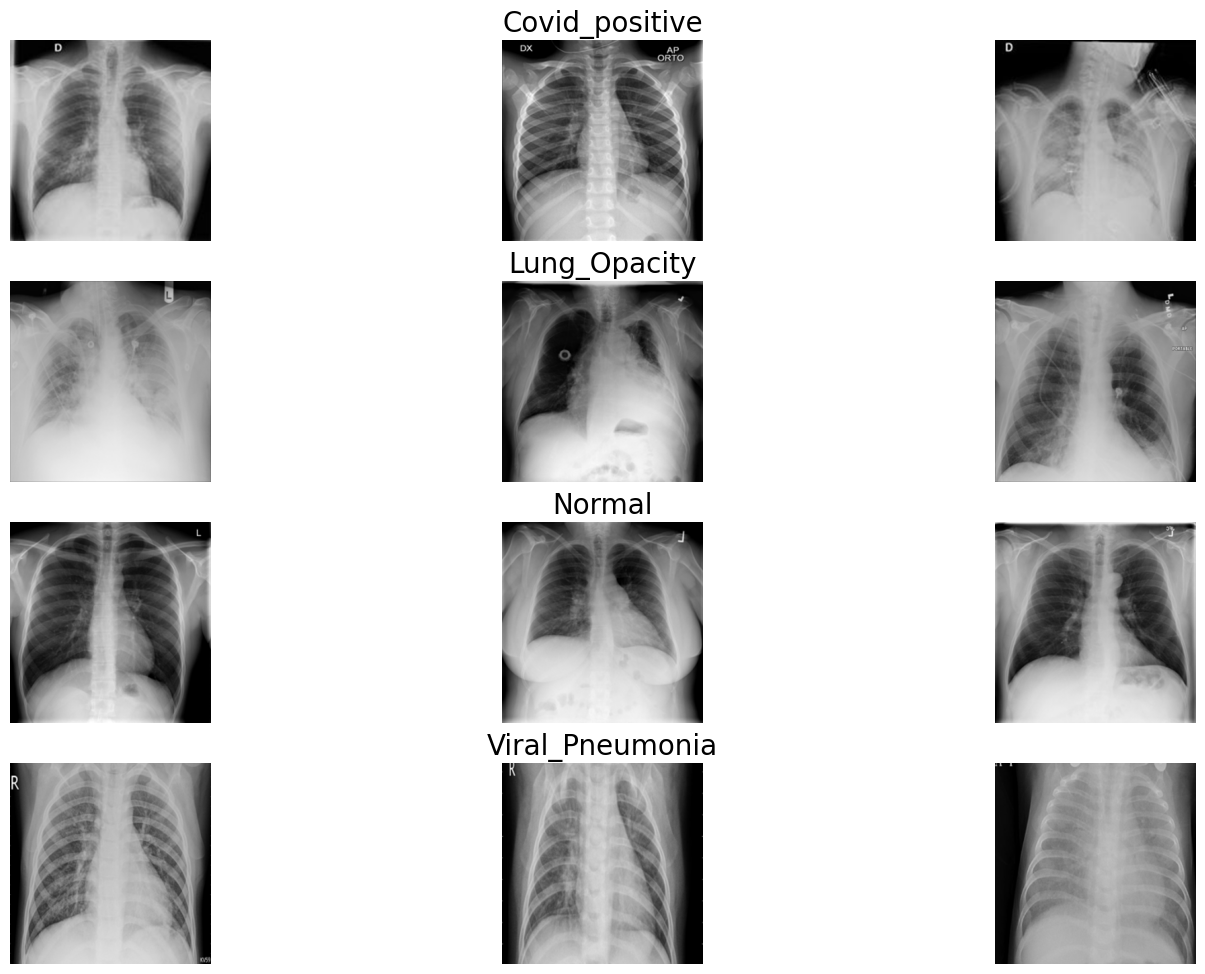

In [15]:
n_samples = 3

fig, m_axs = plt.subplots(4, n_samples, figsize = (6*n_samples, 3*4))

for n_axs, (type_name, type_rows) in zip(m_axs, data.sort_values(['corona_result']).groupby('corona_result')):
    n_axs[1].set_title(type_name, fontsize = 20)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state = 1234).iterrows()):       
        picture = c_row['path']
        image = cv2.imread(picture)
        c_ax.imshow(image)
        c_ax.axis('off')


In [42]:
def random_analysis(image_path):

    image = cv2.imread(image_path)

    # create figure
    fig = plt.figure(figsize=(10, 7))

    # setting values to rows and column variables
    rows = 2
    columns = 3

    # Adds a subplot at the 1st position
    fig.add_subplot(rows, columns, 1)
    plt.title('Original ', fontsize = 14)

    plt.imshow(image)
    plt.axis('off')


    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 2)

    # showing image
    plt.title('B channel', fontsize = 14)
    plt.imshow(image[ : , : , 0])
    plt.axis('off');


    # Adds a subplot at the 2nd position
    fig.add_subplot(rows, columns, 3)

    img = cv2.imread(image_path)
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    plt.title("Ben Graham's Method", fontsize = 14)
    plt.imshow(img)
    plt.axis('off')
    
    list_text = image_path.split("/")

    print("\n-----------------------------{}-----------------------------\n".format("IMAGE DETAILS" + " ( " + list_text[0].upper() + " )"))

    print('Image Shape: {}'.format(image.shape))
    print('Image Height: {}'.format(image.shape[0]))
    print('Image Width: {}'.format(image.shape[1]))
    print('Image Dimension: {}'.format(image.ndim))
    print('Image Size: {}kb'.format(image.size//1024))
    print('Image Data Type: {}'.format(image.dtype))
    print('Maximum RGB value of the image: {}'.format(image.max()))
    print('Minimum RGB value of the image: {}'.format(image.min()))

In [21]:
# list_images_sample = ["C:\\Users\\lenovo\\OneDrive\\Desktop\\Contacttracing\\COVID-19_Radiography_Dataset\\Viral Pneumonia\\images\\Viral Pneumonia-1003.png",
#                      "C:\\Users\\lenovo\\OneDrive\\Desktop\\Contacttracing\\COVID-19_Radiography_Dataset\\Normal\\images\\Normal-10004.png",
#                      "C:\\Users\\lenovo\\OneDrive\\Desktop\\Contacttracing\\COVID-19_Radiography_Dataset\\Lung_Opacity\\images\\Lung_Opacity-1000.png",
#                      "C:\\Users\\lenovo\\OneDrive\\Desktop\\Contacttracing\\COVID-19_Radiography_Dataset\\COVID\\images\\COVID-100.png"]

list_images_sample = ["C:\\Users\\lenovo\\OneDrive\\Desktop\\contact_tracing\\COVID-19_Radiography_Dataset\\Viral Pneumonia\\images\\Viral Pneumonia-1003.png",
                     "C:\\Users\\lenovo\\OneDrive\\Desktop\\contact_tracing\\COVID-19_Radiography_Dataset\\Normal\\images\\Normal-10004.png",
                     "C:\\Users\\lenovo\\OneDrive\\Desktop\\contact_tracing\\COVID-19_Radiography_Dataset\\Lung_Opacity\\images\\Lung_Opacity-1000.png",
                     "C:\\Users\\lenovo\\OneDrive\\Desktop\\contact_tracing\\COVID-19_Radiography_Dataset\\COVID\\images\\COVID-100.png"]


-----------------------------IMAGE DETAILS ( C:\USERS\LENOVO\ONEDRIVE\DESKTOP\CONTACT_TRACING\COVID-19_RADIOGRAPHY_DATASET\VIRAL PNEUMONIA\IMAGES\VIRAL PNEUMONIA-1003.PNG )-----------------------------

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261kb
Image Data Type: uint8
Maximum RGB value of the image: 243
Minimum RGB value of the image: 0


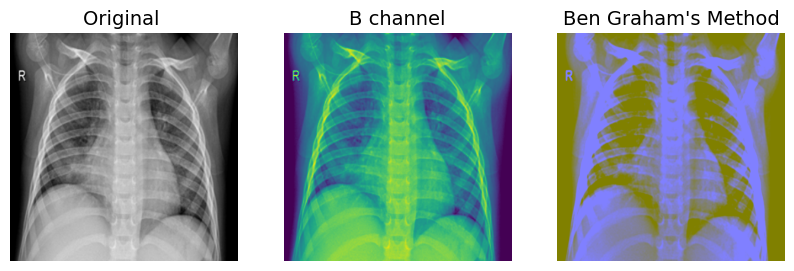

In [43]:
random_analysis(list_images_sample[0])


-----------------------------IMAGE DETAILS ( C:\USERS\LENOVO\ONEDRIVE\DESKTOP\CONTACT_TRACING\COVID-19_RADIOGRAPHY_DATASET\NORMAL\IMAGES\NORMAL-10004.PNG )-----------------------------

Image Shape: (299, 299, 3)
Image Height: 299
Image Width: 299
Image Dimension: 3
Image Size: 261kb
Image Data Type: uint8
Maximum RGB value of the image: 250
Minimum RGB value of the image: 0


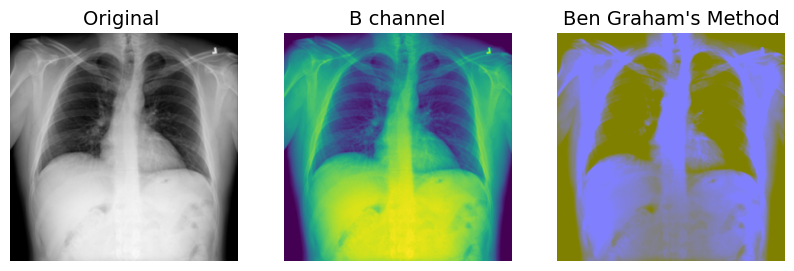

In [44]:
random_analysis(list_images_sample[1])

In [24]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, axis = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        axis[i // ncols][i % ncols].imshow(img)
        axis[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()

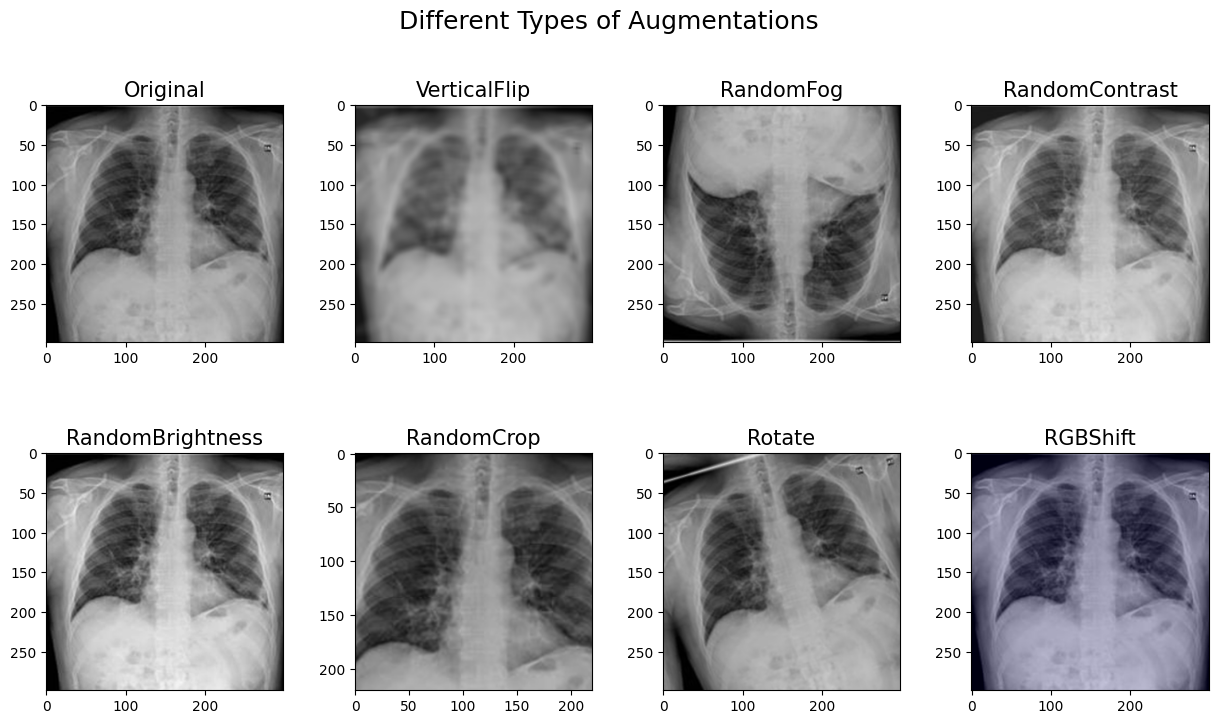

In [26]:
chosen_image = cv2.imread("C:\\Users\\lenovo\\OneDrive\\Desktop\\contact_tracing\\COVID-19_Radiography_Dataset\\COVID\\images\\COVID-101.png")

albumentation_list = [A.RandomFog(p = 1),A.VerticalFlip(p = 1), A.RandomBrightness(p = 1),A.RandomContrast(limit = 0.6, p = 1),
                      A.RandomCrop(p = 1,height = 220, width = 220),
                      A.Rotate(p = 1, limit = 90), A.RGBShift(p = 1)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original", "VerticalFlip", "RandomFog", "RandomContrast", "RandomBrightness", "RandomCrop", "Rotate", "RGBShift"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4, main_title = "Different Types of Augmentations")

In [27]:
all_data = []

# Storing images and their labels into a list for further Train Test split
{'Normal': 'Normal', 'COVID': 'Covid_positive', 'Lung_Opacity':'Lung_Opacity', 'Viral Pneumonia':'Viral_Pneumonia'}
for i in range(len(data)):
    image = cv2.imread(data['path'][i])
    image = cv2.resize(image, (70, 70)) / 255.0
    label = 0
    if data['corona_result'][i] == "Normal":
        label = 0
    elif data['corona_result'][i] == "Covid_positive":
        label = 1
    elif data['corona_result'][i] == "Lung_Opacity":
        label = 2
    else:
        label = 3
    label = 1 if data['corona_result'][i] == "Positive" else 0
    all_data.append([image, label])

In [28]:
x = []
y = []

for image, label in all_data:
    x.append(image)
    y.append(label)

# Converting to Numpy Array    
x = np.array(x)
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 42)

print(x_train.shape, x_test.shape, x_val.shape, y_train.shape, y_test.shape, y_val.shape)


(15238, 70, 70, 3) (4233, 70, 70, 3) (1694, 70, 70, 3) (15238,) (4233,) (1694,)


In [29]:
def create_model(n_classes, train_shape):
    cnn_model = models.Sequential()
    cnn_model.add(layers.Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', input_shape = train_shape))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dropout(0.3))

    cnn_model.add(layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'))
    cnn_model.add(layers.MaxPooling2D((2, 2)))
    cnn_model.add(layers.Dropout(0.5))

    cnn_model.add(layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'))
    cnn_model.add(layers.Flatten())
    cnn_model.add(layers.Dense(units = 16, activation = 'relu'))
    cnn_model.add(layers.Dropout(0.2))

    cnn_model.add(layers.Dense(units = 4))

    cnn_model.compile(optimizer = 'adam', 
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
               metrics = ['accuracy'])

    cnn_model.summary()
    return cnn_model

In [30]:
input_shape = (70, 70, 3)
n_classes= 4

conv_model = create_model(n_classes, input_shape)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 68, 68, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 34, 34, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 64)        0

In [31]:
plot_loss_1 = PlotLossesCallback()

tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

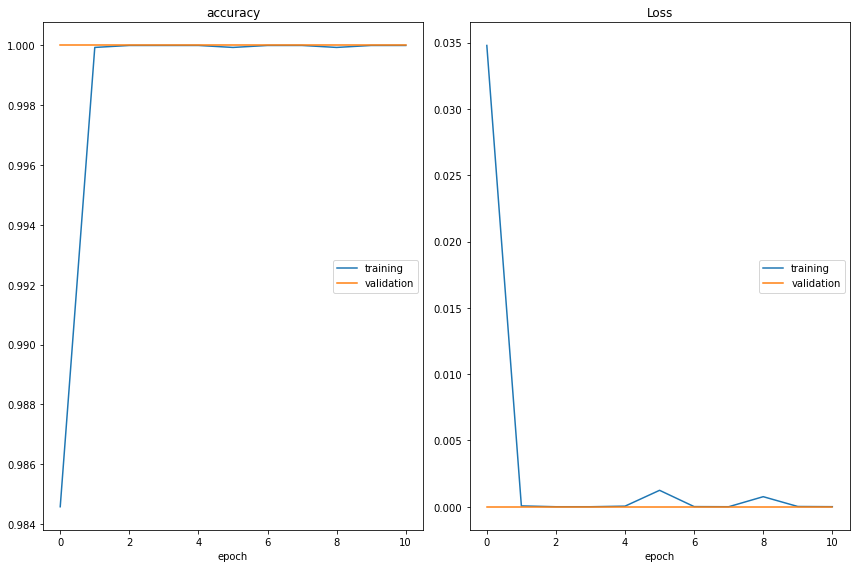

accuracy
	training         	 (min:    0.985, max:    1.000, cur:    1.000)
	validation       	 (min:    1.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    0.000, max:    0.035, cur:    0.000)
	validation       	 (min:    0.000, max:    0.000, cur:    0.000)
60/60 [==============================] - 262s 4s/step - loss: 3.7013e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
CPU times: total: 2h 55min 24s
Wall time: 49min 14s


In [34]:
%%time

plot_loss_2 = PlotLossesCallback()

conv_history = conv_model.fit(x_train, y_train, 
                        epochs = 50, batch_size = 256,  
                        validation_data = (x_val, y_val), 
                        callbacks = [tl_checkpoint_1, early_stop, plot_loss_2],
                       verbose=1)

In [32]:
yp_train = conv_model.predict(x_train)
yp_train = np.argmax(yp_train, axis = 1)

yp_val = conv_model.predict(x_val)
yp_val = np.argmax(yp_val, axis = 1)

yp_test = conv_model.predict(x_test)
yp_test = np.argmax(yp_test, axis = 1)

133/133 [==============================] - 10s 74ms/step


In [33]:
def confusion_matrix_train_test_val(name, y_train, yp_train, y_val, yp_val, y_test, yp_test):
    
    print("\n-----------------------------{}-----------------------------\n".format(name))
    
    
    print("Classification Report for Train Data\n")
    print(classification_report(y_train, yp_train)) 
    print("--------------------------------------------------------------------------")
    
    print("\nClassification Report for Validation Data\n")
    print(classification_report(y_val, yp_val))   
    print("--------------------------------------------------------------------------")

    
    print("\nClassification Report for Test Data\n")
    print(classification_report(y_test, yp_test))   
    print("--------------------------------------------------------------------------")

In [34]:
confusion_matrix_train_test_val("CNN", y_train, yp_train, y_val, yp_val, y_test, yp_test)


-----------------------------CNN-----------------------------

Classification Report for Train Data

              precision    recall  f1-score   support

           0       0.00      0.00      0.00   15238.0
           1       0.00      0.00      0.00       0.0
           3       0.00      0.00      0.00       0.0

    accuracy                           0.00   15238.0
   macro avg       0.00      0.00      0.00   15238.0
weighted avg       0.00      0.00      0.00   15238.0

--------------------------------------------------------------------------

Classification Report for Validation Data

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    1694.0
           3       0.00      0.00      0.00       0.0

    accuracy                           0.00    1694.0
   macro avg       0.00      0.00      0.00    1694.0
weighted avg       0.00      0.00      0.00    1694.0

-----------------------------------------------------------------------

C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.

C:\Users\lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predict

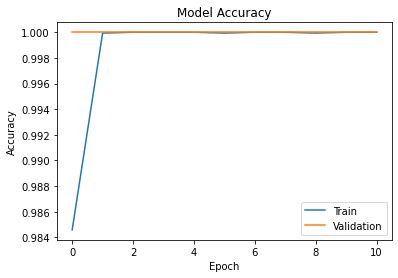

In [38]:
# Summarize History for Accuracy

plt.plot(conv_history.history['accuracy'])
plt.plot(conv_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')
plt.show()

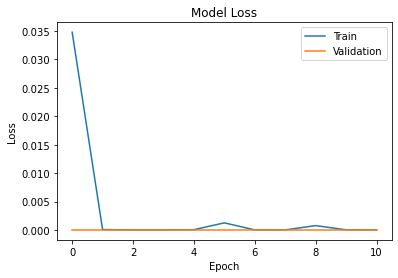

In [39]:
# Summarize History for Loss

plt.plot(conv_history.history['loss'])
plt.plot(conv_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper right')
plt.show()

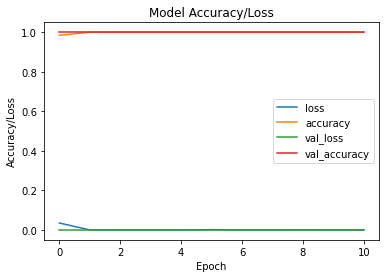

In [40]:
# Accuracy Loss Graph

pd.DataFrame(conv_history.history).plot()
plt.title('Model Accuracy/Loss')
plt.ylabel('Accuracy/Loss')
plt.xlabel('Epoch')
plt.show()

In [35]:
conv_model.save('covid_model.h5')

In [36]:
model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions
imag = []

last_conv_layer_name = "block14_sepconv2_act"

In [37]:
# To Get Image into numpy array

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = size) 
    array = tf.keras.preprocessing.image.img_to_array(img) 
    array = np.expand_dims(array, axis = 0)
    return array

# Top create heatmaps for the samples

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index = None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [38]:
from tensorflow.keras.utils import load_img
covid_noncovid_heatmap = []

for i in list_images_sample:
    img_array = preprocess_input(get_img_array(i, size = img_size))
    model = model_builder(weights = "imagenet")
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    covid_noncovid_heatmap.append(heatmap)

1/1 [==============================] - 1s 962ms/step


In [39]:
def save_and_display_gradcam(img_path, heatmap, cam_path = "cam.jpg", alpha = 0.4):
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    
    imag.append(cv2.imread(img_path))
    imag.append(cv2.imread("./cam.jpg"))


for i in range(len(list_images_sample)):
    save_and_display_gradcam(list_images_sample[i], covid_noncovid_heatmap[i])

C:\Users\lenovo\AppData\Local\Temp\ipykernel_19828\3861237578.py:7: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



In [40]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title = ""):
    
    fig, myaxes = plt.subplots(figsize = (15, 8), nrows = 2, ncols = ncols, squeeze = False)
    fig.suptitle(main_title, fontsize = 18)
    fig.subplots_adjust(wspace = 0.3)
    fig.subplots_adjust(hspace = 0.3)
    
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize = 15)
        
    plt.show()

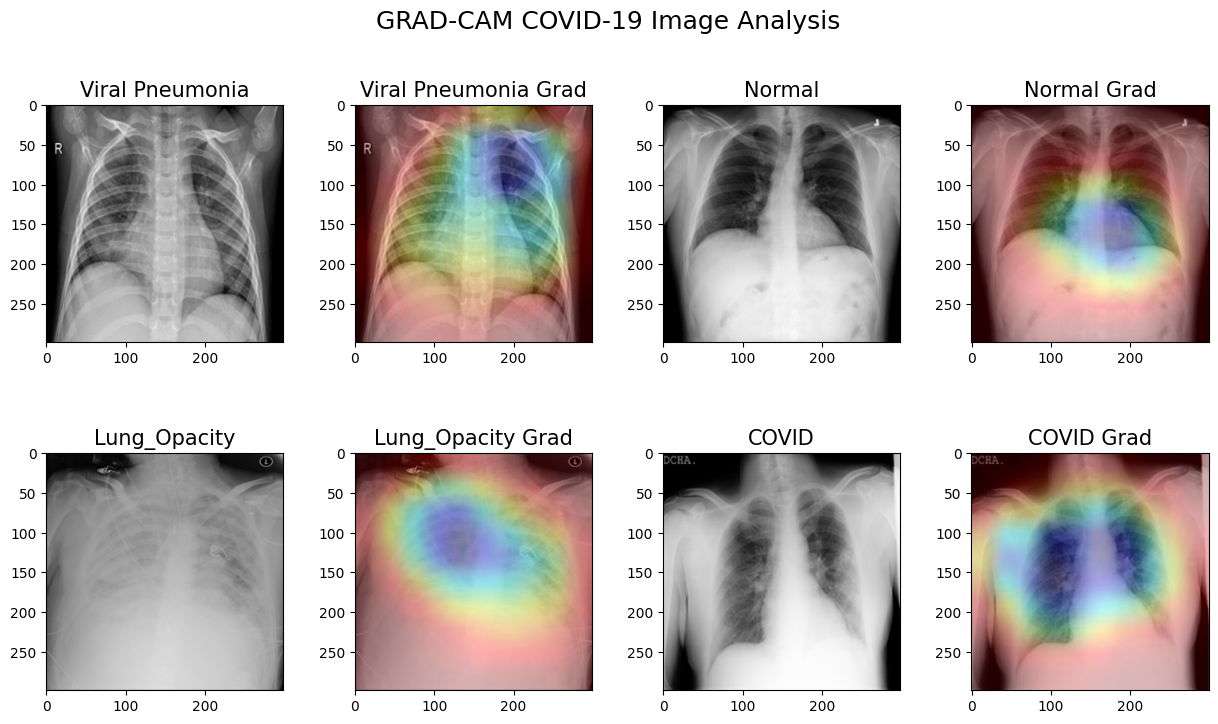

In [41]:
titles_list = ["Viral Pneumonia",'Viral Pneumonia Grad','Normal','Normal Grad','Lung_Opacity','Lung_Opacity Grad','COVID','COVID Grad']

plot_multiple_img(imag, titles_list, ncols = 4, main_title = "GRAD-CAM COVID-19 Image Analysis")

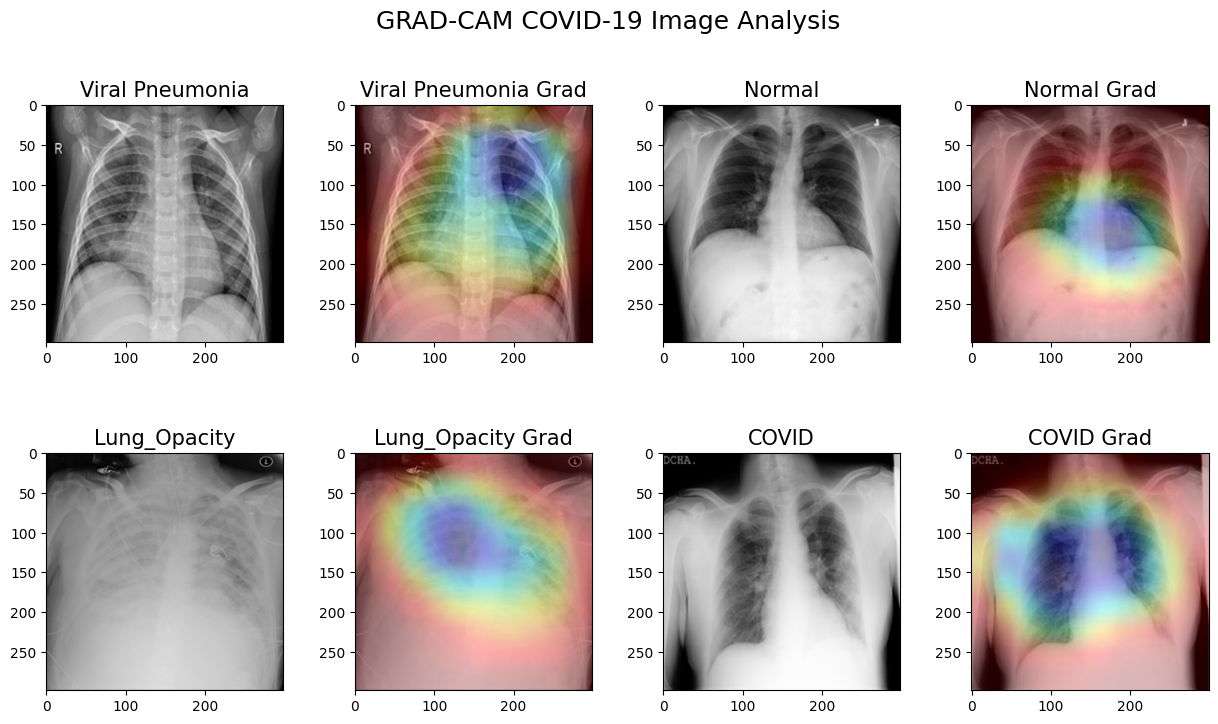

In [45]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(15, 8), nrows=2, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize=18)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)

    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)

    save_folder = "C:\\Users\\lenovo\\OneDrive\\Desktop\\contact_tracing\\COVID-19_Radiography_Dataset\\Image_Analysis"
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)

    image_index_to_save = 2
    custom_image_name = "GRAD-CAM COVID-19 Image Analysis.png"
    save_path = os.path.join(save_folder, custom_image_name)
    myaxes[image_index_to_save // ncols][image_index_to_save % ncols].figure.savefig(save_path)

    plt.show()

# Example usage
titles_list1 = ["Viral Pneumonia", "Viral Pneumonia Grad", "Normal", "Normal Grad", "Lung_Opacity", "Lung_Opacity Grad", "COVID", "COVID Grad"]
# img_matrix_list = [img1, img2, img3, img4, img5, img6, img7, img8]  # Replace img1, img2, ... with actual image matrices
plot_multiple_img(imag, titles_list1, ncols=4, main_title="GRAD-CAM COVID-19 Image Analysis")